In [3]:
import datetime
import importlib

import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np

from model import unet, losses, metrics

import config
from utils import callbacks, display
from dataset import mk_dataset


In [4]:
train_ds = mk_dataset.mk_dataset(
    SAT_PATH=config.TR_SAT_PATH, MAP_PATH=config.TR_MAP_PATH
)
valid_ds = mk_dataset.mk_dataset(
    SAT_PATH=config.VA_SAT_PATH, MAP_PATH=config.VA_MAP_PATH, batch_size=1
)

sample_inp, sample_tar = next(iter(valid_ds))


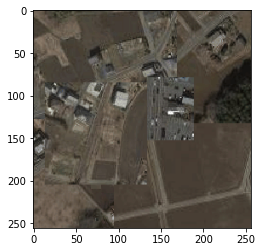

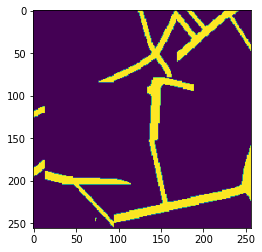

In [3]:
plt.imshow(sample_inp[0])
plt.show()
plt.imshow(sample_tar[0])
plt.show()


In [4]:
for i, t in train_ds.take(1):
    # plt.imshow(i[0])
    # plt.colorbar()
    # plt.show()
    # plt.imshow(t[0])
    # plt.colorbar()
    # plt.show()
    print(i.shape)
    print(t.shape)
    print(np.max(t))
    print(np.max(i))


(64, 256, 256, 3)
(64, 256, 256, 1)
1.0
1.0


In [10]:
importlib.reload(unet)
input_shape = (config.IMG_HEIGHT, config.IMG_WIDTH, config.IMG_CH)
model = unet.big_unet_model(input_shape=input_shape, output_channels=config.OUT_CH)


importlib.reload(losses)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.05),
    # loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    loss=losses.DICELoss(),
    metrics=["accuracy", metrics.iou_coef],
)


In [8]:

keras.utils.plot_model(model,show_dtype=True,show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


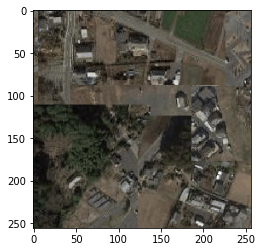

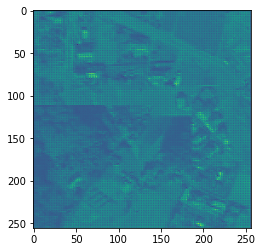

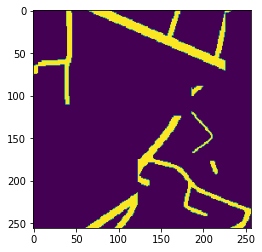


Sample Prediction after epoch 1



In [8]:
importlib.reload(callbacks)
disp_cb = callbacks.DisplayCallback(
    model=model,
    sample_inp=sample_inp[0],
    sample_tar=sample_tar[0],
)
disp_cb.on_epoch_end(0, None)


(64, 256, 256, 3)
1.0
0.0
(64, 256, 256, 1)
1.0
0.0


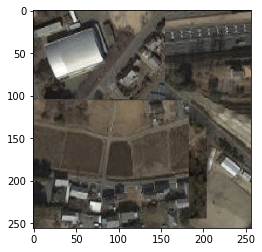

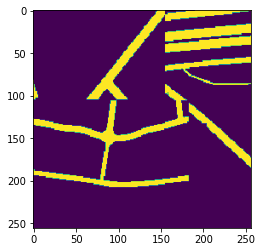

In [7]:
for i, t in train_ds.take(1):
    print(i.shape)
    print(np.max(i))
    print(np.min(i))
    print(t.shape)
    print(np.max(t))
    print(np.min(t))
    plt.imshow(i[0])
    plt.show()
    plt.imshow(t[0])
    plt.show()


In [6]:
tb = callbacks.get_tb_callback('./logs/fit/dice_1110')
cp = callbacks.get_cp_callback('./checkpoint/dice_1110')


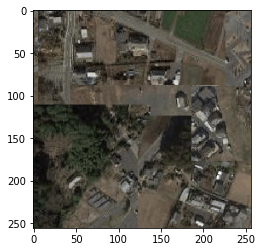

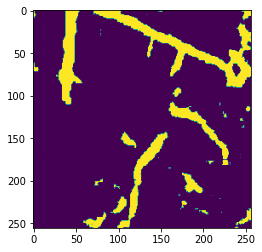

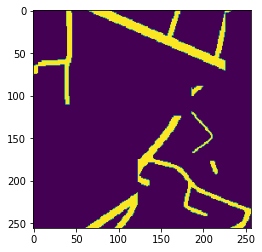


Sample Prediction after epoch 22


Epoch 00022: saving model to ./checkpoint/dice_1110
Epoch 23/80
 8/37 [=====>........................] - ETA: 10s - loss: 0.4039 - accuracy: 0.8879 - iou_coef: 0.4083

In [ ]:
# log_dir = "logs/fit/dice_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = keras.callbacks.TensorBoard(
#     log_dir=log_dir,
#     histogram_freq=1,
# )


model_history = model.fit(
    train_ds,
    epochs=config.EPOCHS*4,
    steps_per_epoch=config.STEPS_PER_EPOCH,
    validation_steps=config.VALIDATION_STEPS,
    validation_data=valid_ds,
    callbacks=[disp_cb, tb, cp],
)


In [ ]:
for i, t in valid_ds.take(2):
    t_pred = model.predict(i)
    plt.imshow(i[0])
    plt.show()
    plt.imshow(t[0])
    plt.show()
    plt.imshow(t_pred[0][:, :, 0])
    plt.show()


In [ ]:
model.save("savedmodel1110")


In [ ]:
loss = model_history.history["loss"]
# val_loss = model_history.history["val_loss"]

plt.figure()
plt.plot(model_history.epoch, loss, "r", label="Training loss")
plt.plot(model_history.epoch, val_loss, "bo", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.ylim([0, 1])
plt.legend()
plt.savefig("10282205.png")
plt.show()


In [ ]:
pred = model.predict(sample_inp)
pred.shape